# Opdracht logistic regression

Logistische regressie is een bijzonder populaire classificatietechniek. Enerzijds door zijn eenvoud en relatief lage eisen die het stelt in termen van rekenkracht. In veel gevallen is de performantie qua accuracy vergelijkbaar (en soms beter) dan gecompliceerdere algoritmes zoals de support vector machines.
Daarnaast heeft logistische regressie het voordeel dat het getrainde model een voorspelling doet in termen van de kans dat de input tot een bepaalde klasse behoort. Uit deze kans kan je afleiden hoe overtuigd het model is van de gemaakte voorspelling.

Het is de bedoeling om via enkele classificatieopdrachten inzicht te verkrijgen in:
- Correct trainen en het uitvoeren van hyperparameter tuning bij logistische regressie.
- Classificaties kunnen uitvoeren via logistische regressie.
- Feature engineering uitvoeren.
- Interpreteren van de verschillende performance metrics: accuracy, recall, precision, f1-score, ROC.
- Kunnen omgaan met niet-gebalanceerde data en het kunnen regelen tussen het aantal false positives en false negatives. 
- Weten wanneer je te maken hebt met overfitting en underfitting en de juiste bijstellingen kunnen doen.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns

## Opdracht 1: Diabetes

Het bestand *diabetes.csv* bevat medische gegevens van meer dan 300 personen waarbij telkens geweten is of de persoon al dan niet diabetes heeft.
Train nu een logic regression model dat op basis van de features een zo goed mogelijke predictie kan doen of iemand al dan niet diabetes heeft.

### Inlezen van de dataset en vooranalyse

In [2]:
# inlezen van de dataset
dataset = pd.read_csv('diabetes.csv')
dataset.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


Controleer of de dataset inconsistenties of foute waarden bevat. Gebruik listwise deletion. Dit betekent dat je alle gegevens van een persoon uit de dataset verwijdert van zodra er 1 feature foutief is of ontbreekt.

In [3]:
# inconsistenties opsporen
# Insuline gehalte moet groter zijn dan 0
dataset= dataset[dataset['Insulin'] > 0]
# SkinThickness moet groter zijn dan 0
dataset= dataset[dataset['SkinThickness'] > 0]
#Glucose gehalte moet groter zijn dan 0
dataset= dataset[dataset['Glucose'] > 0]
#BMI moet groter zijn dan 0
dataset= dataset[dataset['BMI'] > 0]

dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


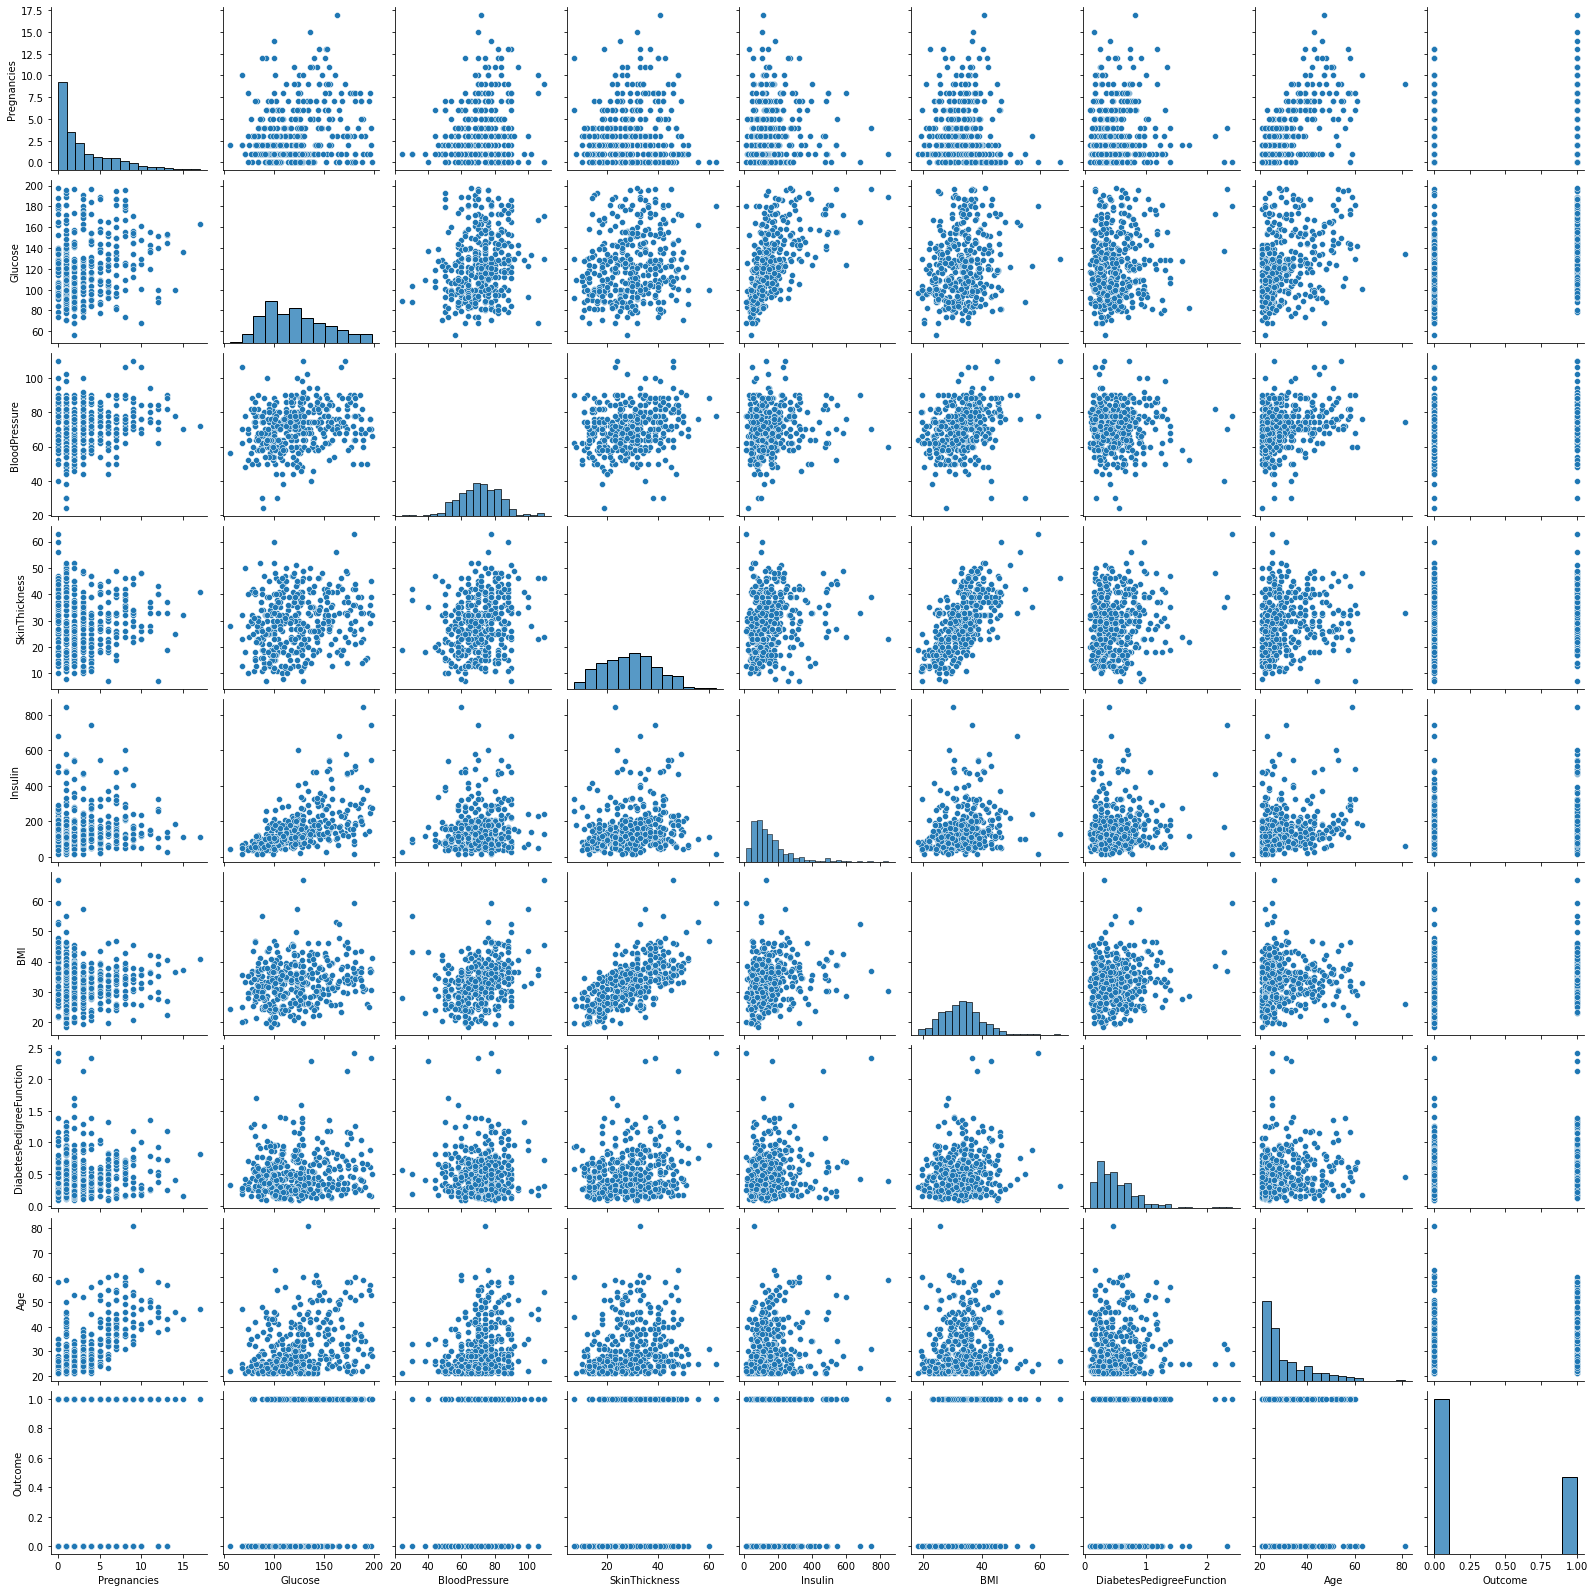

In [4]:
sns.pairplot(dataset)

Bepaal de verdeling van het aantal personen met diabetes ten opzichte van het aantal personen zonder. Is de dataset gebalanceerd?

<AxesSubplot:xlabel='Outcome', ylabel='count'>

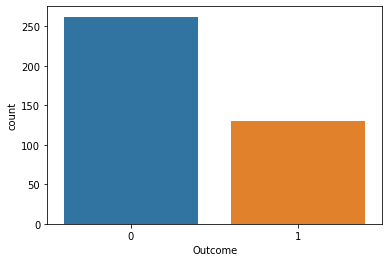

In [4]:
# gebalanceerdheid controleren
sns.countplot(x='Outcome',data=dataset)

Niet perfect gebalanceerd. Er zijn ongeveer dubbel zoveel samples in de negatieve klasse dan in de positieve klasse. Mogelijks krijgt de classifier een voorkeur voor de niet-diabetes klasse.

Bepaal de statistische kerngetallen van de verschillende features en target. Gebruik hiervoor de *describe* functie.

In [5]:
# statistische kerngetallen
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Preprocessing en opsplitsen van de dataset

Splits de dataset in **features en targets**.

In [6]:
# Opsplitsen in features en targets
y = dataset['Outcome'].values
X = dataset.drop(['Outcome'],axis=1).values

Creëer een **trainingset en een testset**. Zorg dat er 100 patiënten in de testset steken. 

In [7]:
# training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=0)

**Schaal de dataset**. Zorg er dus voor dat de features op een gelijke schaalverdeling staan. Voor het scalen kan gebruik gemaakt worden van de *preprocessing.StandardScaler()*. Meer info over het gebruik ervan is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [8]:
# Scaling
# Om conversion warning te vermijden:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

# Scaling

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform((X_train))
X_test = scaler.transform(X_test)

### Trainen van een logistic regression classifier en testen van het bekomen model

Train een logistic regression classifier op de training data. Kies C=1 als startwaarde. Mocht de dataset niet gebalanceerd zijn (de ene klasse komt frequenter voor dan de andere klasse) dan kan je bij de creatie van het logistic regression model de parameter class_weight='balanced' meegeven. Meer info: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Test het getrainde model op de test set. Bepaal hierbij de confusion matrix, de accuracy en het classification report. Wat zijn de bevindingen? Probeer ook verschillende solvers uit. Bepaal ook telkens de ROC en formuleer conclusies.

Probeer de performantie van de classifier te verhogen door de parameter C te veranderen.

Evalueer de modellen telkens via de confusion matrix, classification report en indien mogelijk via de ROC-curve. Bespreek de resultaten.

              precision    recall  f1-score   support

           0       0.72      0.97      0.82        65
           1       0.83      0.29      0.43        35

    accuracy                           0.73       100
   macro avg       0.77      0.63      0.62       100
weighted avg       0.76      0.73      0.68       100

73.0
[[63  2]
 [25 10]]


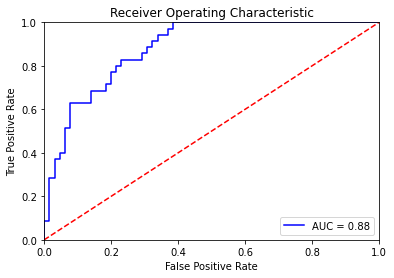

In [16]:
# hyperparameter tuning

logreg = linear_model.LogisticRegression(C=0.01, penalty = 'l2',multi_class='auto',solver = 'saga')

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

print(classification_report(y_test,y_pred))

print(accuracy_score(y_test,y_pred)*100)

print(confusion_matrix(y_test,y_pred))


import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

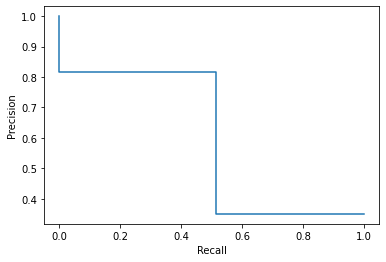

In [14]:
# Precision recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()



In [17]:
print(logreg.coef_)

[[0.07931291 0.353548   0.10013042 0.12663049 0.10831469 0.14034891
  0.12364768 0.15769869]]


Omwille van de niet-gebalanceerdheid verklaart de accuracy maar een deel van het verhaal. De recall op de negatieve klasse ligt een pak hoger dan deze op de positieve klasse.
De ROC-curve is hier ook misleidend. 
Beter is om de precision-recall curve te plotten. Daar kan je zien dat om de recall te verhogen, er heel veel aan preciese wordt ingeboet.

Je kan ervoor opteren om de recall van de diabetes klasse te verhogen (dus meer detectie van diabetes gevallen en minder false negatives).

Een eerste stap kan zijn om class_weight op balanced te plaatsen of manueel aan te passen.

              precision    recall  f1-score   support

           0       0.81      0.80      0.81        65
           1       0.64      0.66      0.65        35

    accuracy                           0.75       100
   macro avg       0.73      0.73      0.73       100
weighted avg       0.75      0.75      0.75       100

75.0
[[52 13]
 [12 23]]


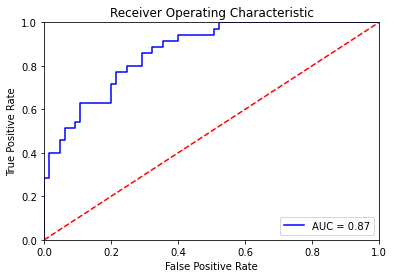

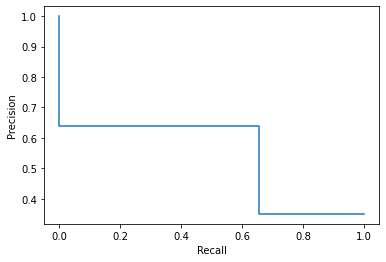

In [12]:
# class_weight = 'balanced'

logreg = linear_model.LogisticRegression(C=1, penalty = 'l2',multi_class='auto',solver = 'saga',class_weight='balanced')

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

print(classification_report(y_test,y_pred))

print(accuracy_score(y_test,y_pred)*100)

print(confusion_matrix(y_test,y_pred))


import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()


Bij class_weight gaat de recall van de minderheidsklasse naar boven, dit echter ten koste van de recall op de meerderheidsklasse en de accuracy.
De AUROC neemt lichtjes toe

              precision    recall  f1-score   support

           0       1.00      0.43      0.60        65
           1       0.49      1.00      0.65        35

    accuracy                           0.63       100
   macro avg       0.74      0.72      0.63       100
weighted avg       0.82      0.63      0.62       100

63.0
[[28 37]
 [ 0 35]]


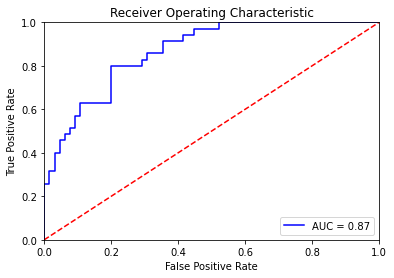

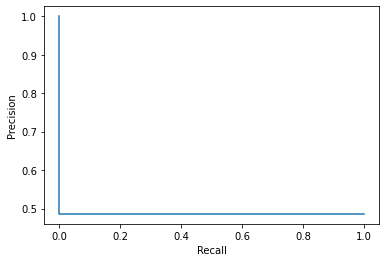

In [13]:
# Classweight manueel verhogen om de de classifier meer diabetes te laten ontdekken

# class_weight = 'balanced'

logreg = linear_model.LogisticRegression(C=1, penalty = 'l2',multi_class='auto',solver = 'saga',class_weight={0:1,1:11})

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

print(classification_report(y_test,y_pred))

print(accuracy_score(y_test,y_pred)*100)

print(confusion_matrix(y_test,y_pred))


import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

Door de klasse diabetes 11 keer (via trial en error bepaald) zwaarder te laten doorwegen dan de minderheidsklasse worden alle diabetes gevallen ontdekt (recall = 1).
Echter heeft de accuracy en de precision hier zwaar onder te lijden.

### Feature engineering
Creeër hogere orde features door gebruik te maken van *preprocessing.PolynomialFeatures*. Meer info is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Deze functie zal automatische hogere orde features aanmaken door het combineren van de aanwezige features. Heb je bijvoorbeeld drie features, zijnde A, B en C dan worden bij de keuze van een derde orde PolynomialFeatures volgende nieuwe features bijgemaakt:
$A^3, B^3,C^3,A^2B,A^2C,AB^2, B^2C,...$

Experimenteer met verschillende ordes en gebruik de regularisatieparameter C om de performantie te verhogen. Voor indien nodig ook regularisatie uit via een L1 of L2 penalty.

**Opgepast**: het kiezen van een te hoge orde zorgt voor een exponentiële toename aan features waardoor de logistic regression classifier niet meer binnen aanvaardbare tijd getraind kan worden. Advies is om niet hoger te gaan dan 4de orde.

dimensie van X_train_poly:  (292, 45)
dimensie van X_test_poly:  (100, 45)
              precision    recall  f1-score   support

           0       0.75      0.97      0.85        65
           1       0.88      0.40      0.55        35

    accuracy                           0.77       100
   macro avg       0.81      0.68      0.70       100
weighted avg       0.79      0.77      0.74       100

[[63  2]
 [21 14]]
accuracy op de test set: 77.0
accuracy op de training set: 77.73972602739725


/home/wouter/miniconda3/envs/tensorflow2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


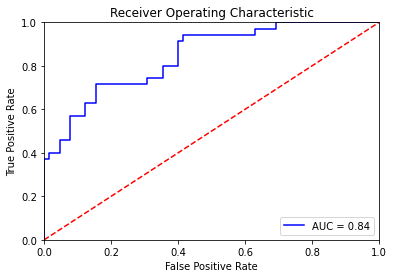

coefficienten: 

[[ 0.          0.          0.75879432  0.          0.06571753  0.
   0.07474026  0.          0.10240135  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.0072408   0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.         -0.02285866  0.          0.          0.          0.
   0.          0.          0.        ]]


In [20]:
# Toevoegen van extra features
# Toevoegen van extra features

# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)

logreg_poly = linear_model.LogisticRegression(C=0.05,solver='saga',multi_class='auto',penalty='l1')

logreg_poly.fit(X_train_poly,y_train)

y_pred_poly = logreg_poly.predict(X_test_poly)

print(classification_report(y_test,y_pred_poly))

print(confusion_matrix(y_test,y_pred_poly))

print('accuracy op de test set:', accuracy_score(y_test,y_pred_poly)*100)

print('accuracy op de training set:', accuracy_score(y_train,logreg_poly.predict(X_train_poly))*100)



import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg_poly.predict_proba(X_test_poly)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


print('coefficienten: \n')
print(logreg_poly.coef_)

Wat zijn de bevindingen? Formuleer een conclusie. Bespreek hierin de performantie van de getrainde modellen. Wat is de invloed van de parameter C en van het aantal features? Heb je te maken gehad met underfitting en overfitting en hoe heb je dit bepaald? Welke accuracy werd bekomen en hoe zit het met de Recall en Precision? Is de grootte van de trainingset voldoende?

Antwoord: Het toevoegen van extra features leidt hier niet echt tot beter resultaten. 
Hoe hoger de graad van het polynoom, des te hoger de kans op overfitting. 
Dit kan je testen zien aan het feit dat de accuracy op de trainig set hoog is maar beduidend lager op de test set. 
Het zou beter zijn mochten er nieuwe relevante features zijn die ervoor zorgen dat het discriminerend vermogen van de classifier toeneemt.

Ook hier lijkt L1 regularisatie het best te scoren.

We kunnen ook proberen niet relevante features uit de dataset te verwijderen. Om de minder relevante features op te sporen kunnen we een logistic regression model trainen met een sterke L1 regularisatie.
De coëfficiënten die daarbij op nul worden gezet komen overeen met de features die voor het model minder belangrijk.

In [15]:
logreg = linear_model.LogisticRegression(C=0.1, penalty = 'l1',multi_class='auto',solver = 'saga')

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

print(classification_report(y_test,y_pred))

print(accuracy_score(y_test,y_pred)*100)

print(confusion_matrix(y_test,y_pred))

print(logreg.coef_)

dataset.describe()

              precision    recall  f1-score   support

           0       0.77      0.94      0.85        65
           1       0.81      0.49      0.61        35

    accuracy                           0.78       100
   macro avg       0.79      0.71      0.73       100
weighted avg       0.79      0.78      0.76       100

78.0
[[61  4]
 [18 17]]
[[0.         0.92368353 0.         0.14199726 0.         0.18287766
  0.12455071 0.2240041 ]]


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.301020,122.627551,70.663265,29.145408,156.056122,33.086224,0.523046,30.864796,0.331633
std,3.211424,30.860781,12.496092,10.516424,118.841690,7.027659,0.345488,10.200777,0.471401
min,0.000000,56.000000,24.000000,7.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.750000,28.400000,0.269750,23.000000,0.000000
50%,2.000000,119.000000,70.000000,29.000000,125.500000,33.200000,0.449500,27.000000,0.000000
75%,5.000000,143.000000,78.000000,37.000000,190.000000,37.100000,0.687000,36.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [16]:
# We verwijderen volgende features:

#- Pregnancies
#- BloodPressure


dataset.drop(['Pregnancies','BloodPressure'],axis=1,inplace=True)

              precision    recall  f1-score   support

           0       0.78      0.94      0.85        65
           1       0.82      0.51      0.63        35

    accuracy                           0.79       100
   macro avg       0.80      0.73      0.74       100
weighted avg       0.79      0.79      0.78       100

79.0
[[61  4]
 [17 18]]


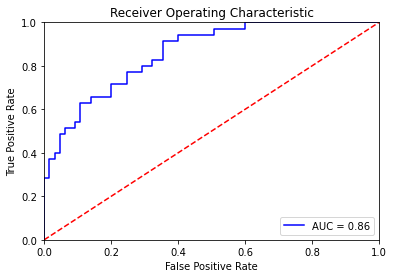

In [17]:
# Opsplitsen in features en targets
y = dataset['Outcome'].values
X = dataset.drop(['Outcome'],axis=1).values

# training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=0)

# Scaling
# Om conversion warning te vermijden:
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

# Scaling

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform((X_train))
X_test = scaler.transform(X_test)

logreg = linear_model.LogisticRegression(C=100000000, penalty = 'l1',multi_class='auto',solver = 'saga')

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

print(classification_report(y_test,y_pred))

print(accuracy_score(y_test,y_pred)*100)

print(confusion_matrix(y_test,y_pred))


import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Feature selection levert geen beter resultaat op

### Voorspel aan de hand van het getrainde model

Voorspel of iemand met onderstaande medische parameters als dan niet diabetes heeft. Geef ook de zekerheid van het model weer (kansen dat de patiënt tot een bepaalde klasse behoort).

Pregnancies: 2 -
Glucose: 132 -
BloodPressure: 74 - 
SkinThickness: 20 - 
Insulin: 21 - 
BMI: 24.3 - 
DiabetesPedigreeFunction: 128 - 
Age: 37

In [21]:
# voorspelling
patient = np.array([[2, 132, 74, 20, 21, 24.3, 1.28, 37]])
patient_poly = poly.transform(patient)

scaler = preprocessing.StandardScaler().fit(X_train_poly)
patient_poly = scaler.transform(patient_poly)

y_patient_poly = logreg_poly.predict(patient_poly)
y_patient_poly_prob = logreg_poly.predict_proba(patient_poly)

print(patient)
print(y_patient_poly_prob)

[[  2.   132.    74.    20.    21.    24.3    1.28  37.  ]]
[[0. 1.]]


Standaard zal het model een sample toewijzen aan klasse 1 van zodra de probiliteit boven de threshold van 50% uisteekt. 
Men wil echter de kans op false negatives drastisch verminderen door het aanpassen van de threshold. Welke threshold moet men instellen om ervoor te zorgen dat het model op de test set geen false negatives meer voorspelt en toch nog een zo hoog mogelijke accuraatheid heeft?
Stel het aantal false negatives in functie van de threshold grafisch voor. Bespreek de resultaten.

[Text(0.5, 0, 'probability threshold'), Text(0, 0.5, 'accuracy')]

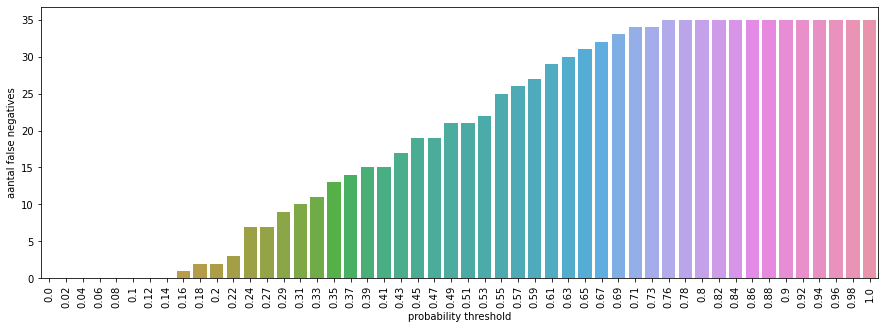

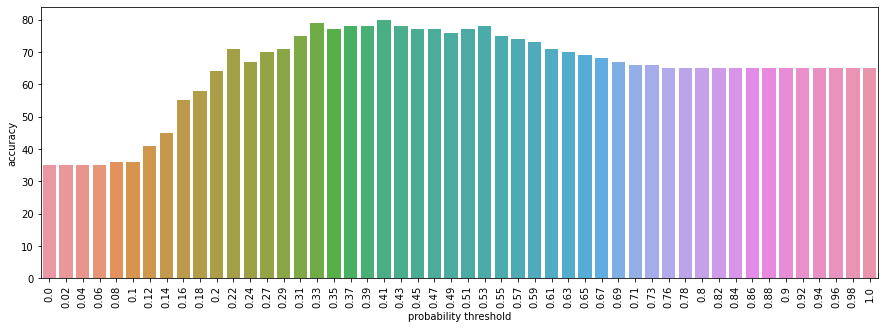

In [23]:
# reduceren van het aantal false negatives door de threshold aan te passen. model voorspelt geen diabet terwijl de patient wel
# diabetes heeft.


# predicties op de test set

y_pred_poly_prob = logreg_poly.predict_proba(X_test_poly)
#print(y_pred_poly_prob)
y_pred_poly_class = y_pred_poly_prob[:,1]

false_negatives = []
accuracy = []
for threshold in np.linspace(0,1,50):
    y_pred_poly_class = y_pred_poly_prob[:,1].copy()
    #print(y_pred_poly_class)
    y_pred_poly_class[y_pred_poly_class>=threshold]=1
    y_pred_poly_class[y_pred_poly_class<threshold]=0
    #print(y_pred_poly_class)
    false_negatives.append(confusion_matrix(y_test,y_pred_poly_class)[1,0])
    accuracy.append(accuracy_score(y_test,y_pred_poly_class)*100)
false_negatives = np.asarray(false_negatives)
#plt.bar(np.linspace(0,1,50),false_negatives)
plt.figure(figsize=(15,5))
chart = sns.barplot(x=np.round(np.linspace(0,1,50),2),y=false_negatives)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set(xlabel='probability threshold', ylabel='aantal false negatives')

plt.figure(figsize=(15,5))
chart = sns.barplot(x=np.round(np.linspace(0,1,50),2),y=accuracy)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.set(xlabel='probability threshold', ylabel='accuracy')

Een threshold van 0.14 zorgt er net voor dat er geen false negatives optreden en dat er een accuraatheid behaald wordt van ongeveer 55%

## Opdracht 2. Human resources

Een groot bedrijf probeert te voorspellen of een werknemer binnenkort al dan niet het bedrijf zal verlaten en hoopt zo tijdig te kunnen ingrijpen.
Gebruik logistische regressie op de dataset 'Human_Resources.csv' om een zo accuraat mogelijk model te trainen. 
Tevens wil het bedrijf vooral false negatives vermijden.
Welke zijn de top 3 features die het sterkst bepalen of een werknemer het bedrijf zal verlaten?

De dataset bestaat uit de volgende features:

- satisfaction_level: mate van voldoening op het werk.
- last_evaluationTime: aantal jaar sinds de laatste evaluatie.
- number_project: het aantal projecten die de werknemer op het bedrijf heeft afgewerkt.
- average_montly_hours: het aantal uur die de werknemer gemiddeld per maand aanwezig is op de werkplaats.
- time_spend_company: het aantal jaar in dienst van het bedrijf.
- work_accident: of de werknemer al een werkongeval heeft gehad.
- promotion_last_5years: of de werknemer al dan niet een promotie heeft gehad de afgelopen 5 jaar.
- department: het departement waar de werknemer voor werkt.
- salary: relatief loon (low, medium, high).

De te voorspellen target = left: of de werknemer het bedrijf al dan niet heeft verlaten (0 of 1)

Gebruik one-hot encoding om categorische features om te zetten naar one-hot features.

Evalueer telkens via de confusion matrix, classification report en ROC-curve. Zorg voor een test set die uit 25% van de volledige dataset bestaat.

Voorspel de kans dat volgende werknemer het bedrijf zal verlaten: 
satisfaction level = 0.54; 
last_evaluation = 0.73;
number_project = 3;
averag_montly_hours = 270;
time_spend_company = 6;
work_accident = 1;
promotion_last_5years = 0;
departments =  technical;
salary = low

In [20]:
dataset = pd.read_csv('Human_Resources.csv')
print('Dimensie van de dataset:',dataset.shape)
dataset.head()

Dimensie van de dataset: (14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [21]:
# uitwerking opdracht human resources



## Opdracht 3.  Star Wars

Train een logistic regression classifier aan de hand van de dataset 'StarWars.csv') om te voorspellen of iemand al dan niet een Star Wars fan is.
Gebruik one-hot encondig waar nodig. Zorg ervoor dat de test set uit minstens 200 samples bestaat.
Evalueer de getrainde classifier via de geziene metrics en bespreek de resultaten.

In [22]:
dataset = pd.read_csv('StarWars.csv')
dataset.head()

,Have you seen any of the 6 films in the Star Wars franchise?,Please rank The Phantom Menace,Please rank attack of the clones,Please rank Revenge of the Sith,Plesase rank a new hope,Please rank The Empire Strikes Back,Please rank Return of the Jedi,Han Solo,Luke Skywalker,Princess Leia Organa,...,Age,Education,phantom menace seen,attack of the clones seen,revenge of the sith seen,a new hope seen,empire strikes back seen,return of the jedi seen,Location,StarWars fan
0,Yes,1.0,2.0,3.0,4.0,5.0,6.0,Somewhat favorably,Somewhat favorably,Somewhat favorably,...,18-29,High school degree,Yes,Yes,Yes,No,No,No,South Atlantic,No
1,Yes,5.0,6.0,1.0,2.0,4.0,3.0,Very favorably,Very favorably,Very favorably,...,18-29,Some college or Associate degree,Yes,Yes,Yes,Yes,Yes,Yes,South Atlantic,Yes
2,Yes,1.0,4.0,3.0,6.0,5.0,2.0,Very favorably,Very favorably,Very favorably,...,18-29,Bachelor degree,Yes,Yes,Yes,Yes,Yes,Yes,West South Central,Yes
3,Yes,4.0,5.0,6.0,3.0,2.0,1.0,Very favorably,Somewhat favorably,Very favorably,...,18-29,High school degree,Yes,Yes,Yes,Yes,Yes,Yes,West North Central,Yes
4,Yes,1.0,2.0,3.0,4.0,5.0,6.0,Neither favorably nor unfavorably (neutral),Very favorably,Very favorably,...,18-29,Some college or Associate degree,No,Yes,No,No,No,No,Middle Atlantic,No


## Opdracht 4. Menselijke activiteit


De dataset 'activiteit.csv' bevat meetgegevens die van 30 personen via een smartphone werden afgenomen. Deze meetwaarden zijn onderandere afkomstig van een accelerometer en een gyroscoop die in de smartphone zijn ingebouwd.
De bedoeling is om om basis van deze meetwaarden de activiteit van de persoon zo nauwkeurig mogelijk te kunnen inschatten.
Er zijn 6 verschillende klasses.


Bepaal de 6 verschillende klasses en onderzoek meteen of de dataset gebalanceerd is (gelijkmatige verdeling van de verschillende klasses).
Bouw een logistic regression model dat zo accuraat mogelijk de activiteit van de persoon kan bepalen. Hierbij pas je alle nodige preprocessing stappen toe je nodig acht.
Het is ook toegestaann om features bij te maken of weg te laten. 

Schrijf jouw conclusies op met betrekking tot het finaal bekomen model.

Print de coëfficiënten van het model. Verklaar nu de dimensie van deze coëfficiëntenmatrix.




In [23]:
dataset = pd.read_csv('activiteit.csv')
dataset.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [24]:
# Uitwerking opdracht menselijke activiteit

